In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
compatibility_file = "resnet34_sparsity_ratio.txt"
results_dir  = "../Early-Bird-Tickets/results_macro_masks/cifar10/resnet34"

In [4]:
type_of_mask = os.listdir(results_dir)
timestep = sorted([int(ts) for ts in os.listdir(os.path.join(results_dir, type_of_mask[0]))])

In [5]:
ratio = np.loadtxt(compatibility_file, delimiter=',')
sparse_ratio={}
sparse_ratio['iou'] = ratio[:, -1]
sparse_ratio['struct'] = ratio[:, 0]
sparse_ratio['unstruct'] = ratio[:, 1]

In [6]:
results = {}
for mask in type_of_mask:
    results[mask] = {}
    for ts in timestep:
        results[mask][ts] = {}
        record = np.loadtxt(os.path.join(results_dir, mask, str(ts), 'record.txt'), delimiter=',')
        results[mask][ts]['best_results'] = record[-1][0]
        results[mask][ts]['losses'] = record[0:-1, 0]
        results[mask][ts]['acc'] = record[0:-1, -1]
        results[mask][ts]['sparsity'] = sparse_ratio[mask][ts]

Text(0.5, 1.0, 'sparsity ratio over time')

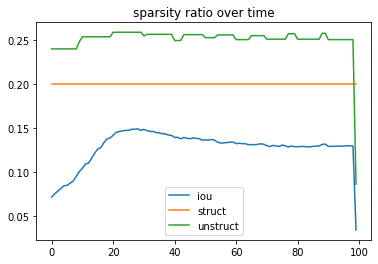

In [63]:
# plot compatibility overtime
fig, ax = plt.subplots()
n_step = len(sparse_ratio['iou'])
ax.plot(np.arange(n_step), sparse_ratio['iou'], label='iou')
ax.plot(np.arange(n_step), sparse_ratio['struct'], label='struct')
ax.plot(np.arange(n_step), sparse_ratio['unstruct'], label='unstruct')
ax.legend()
ax.set_title("sparsity ratio over time")

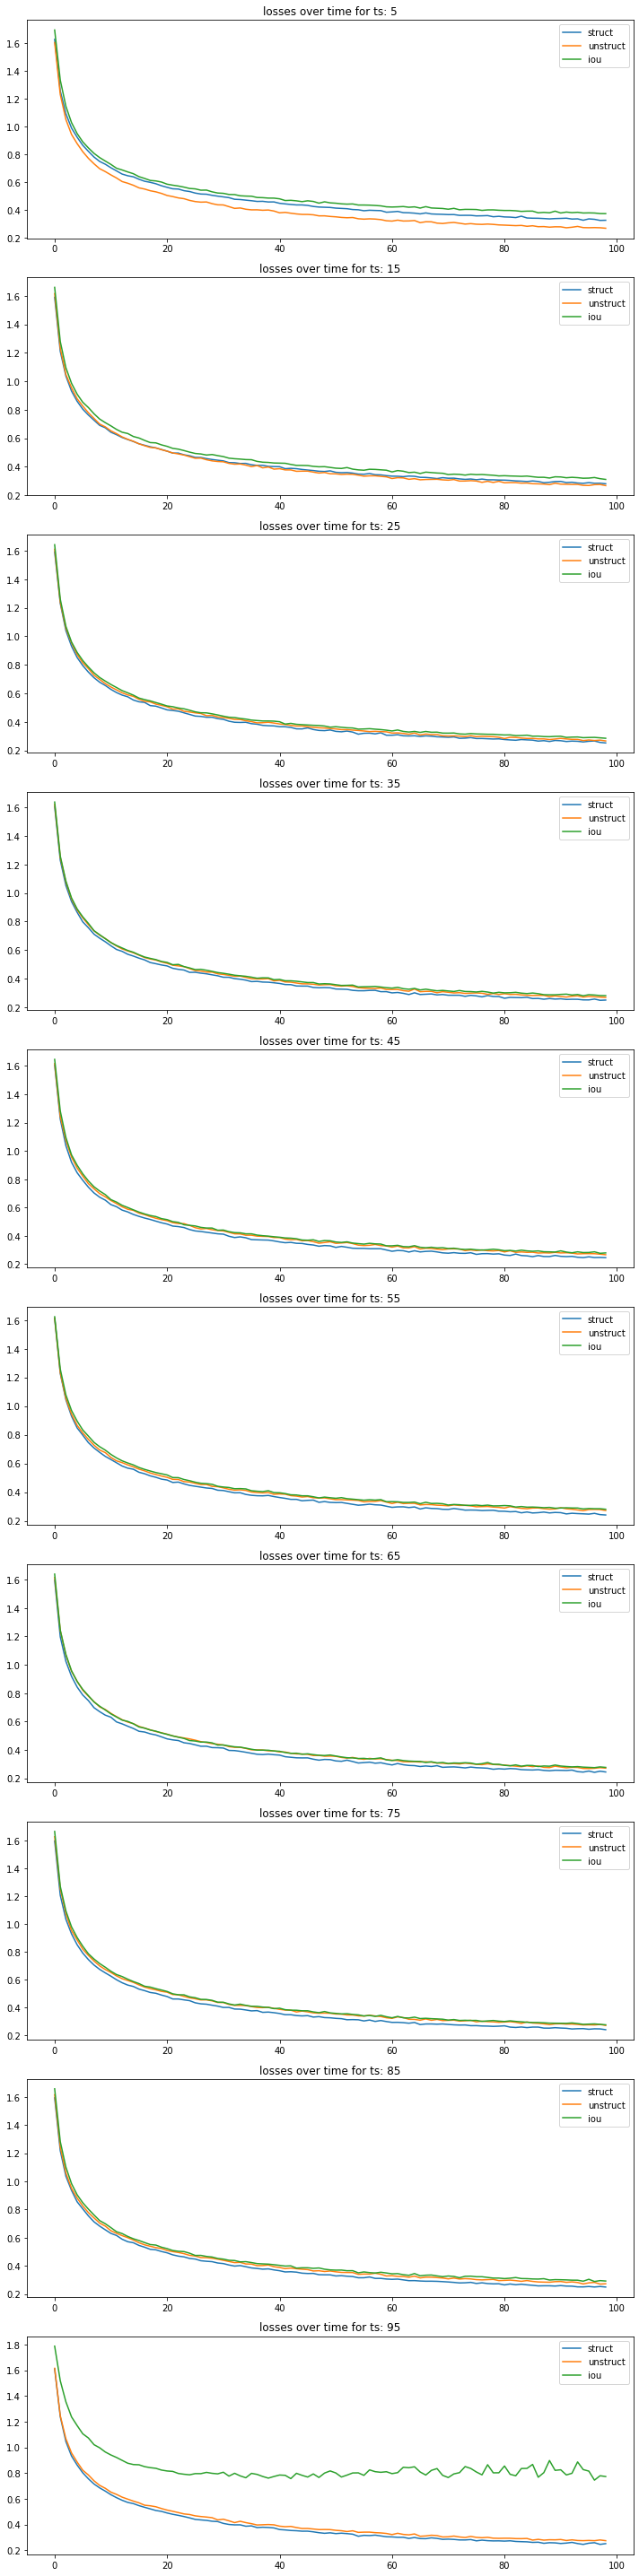

In [73]:
fig, ax = plt.subplots(len(timestep), figsize=(10, 40))

for i, ts in enumerate(timestep):
    for mask in type_of_mask:
        losses = results[mask][ts]['losses']
        x = np.arange(len(losses))
        ax[i].plot(x, losses, label=mask)
    ax[i].legend()
    ax[i].set_title(f'losses over time for ts: {ts}')
fig.tight_layout()

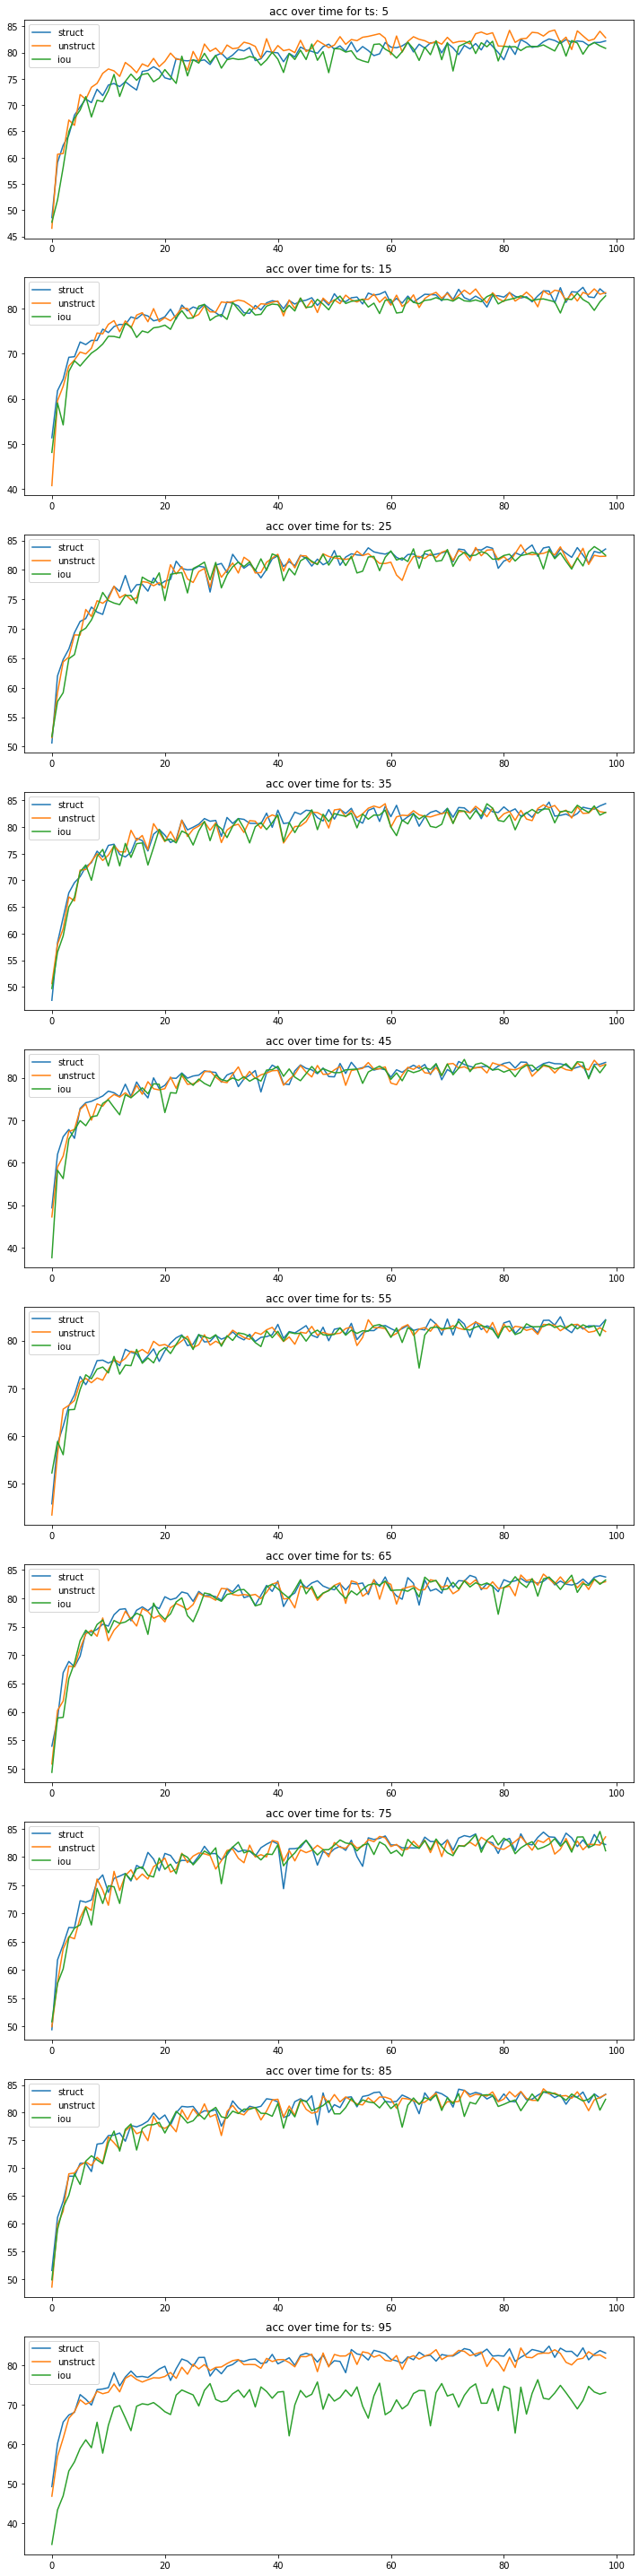

In [75]:
fig, ax = plt.subplots(len(timestep), figsize=(10, 40))

for i, ts in enumerate(timestep):
    for mask in type_of_mask:
        losses = results[mask][ts]['acc']
        x = np.arange(len(losses))
        ax[i].plot(x, losses, label=mask)
    ax[i].legend()
    ax[i].set_title(f'acc over time for ts: {ts}')
fig.tight_layout()

In [9]:
# from https://github.com/VITA-Group/TENAS/blob/main/lib/procedures/ntk.py

def get_ntk_n(xloader, networks, recalbn=0, train_mode=False, num_batch=-1):
    device = torch.cuda.current_device()
    # if recalbn > 0:
    #     network = recal_bn(network, xloader, recalbn, device)
    #     if network_2 is not None:
    #         network_2 = recal_bn(network_2, xloader, recalbn, device)
    ntks = []
    for network in networks:
        if train_mode:
            network.train()
        else:
            network.eval()
    ######
    grads = [[] for _ in range(len(networks))]
    for i, (inputs, targets) in enumerate(xloader):
        if num_batch > 0 and i >= num_batch: break
        inputs = inputs.cuda(device=device, non_blocking=True)
        for net_idx, network in enumerate(networks):
            network.zero_grad()
            inputs_ = inputs.clone().cuda(device=device, non_blocking=True)
            logit = network(inputs_)
            if isinstance(logit, tuple):
                logit = logit[1]  # 201 networks: return features and logits
            for _idx in range(len(inputs_)):
                logit[_idx:_idx+1].backward(torch.ones_like(logit[_idx:_idx+1]), retain_graph=True)
                grad = []
                for name, W in network.named_parameters():
                    if 'weight' in name and W.grad is not None:
                        grad.append(W.grad.view(-1).detach())
                grads[net_idx].append(torch.cat(grad, -1))
                network.zero_grad()
                torch.cuda.empty_cache()
    ######
    grads = [torch.stack(_grads, 0) for _grads in grads]
    ntks = [torch.einsum('nc,mc->nm', [_grads, _grads]) for _grads in grads]
    conds = []
    for ntk in ntks:
        eigenvalues, _ = torch.symeig(ntk)  # ascending
        conds.append(np.nan_to_num((eigenvalues[-1] / eigenvalues[0]).item(), copy=True, nan=100000.0))
    return conds

In [8]:
import torch
import torchvision
from torchvision import datasets
from torchvision import transforms

train_loader = torch.utils.data.DataLoader(datasets.CIFAR10(
        './data.cifar10',
        train=True,
        download=True,
        transform=transforms.Compose([
            transforms.Pad(4),
            transforms.RandomCrop(32),
            transforms.RandomHorizontalFlip(),
            transforms.Lambda(lambda x: filters.gaussian_filter(x, 1.0) if
                              'none' == 'lowpass' else x),
            transforms.Lambda(
                lambda x: my_gaussian_filter_2(x, 1 / 1.0, 'none')
                if 'none' == 'highpass' else x),
            transforms.ToTensor(),
            transforms.Lambda(lambda x: torch.where(x > 0.0, x,
                                                    torch.zeros_like(x))
                              if 0.2 > 0 else x),
            transforms.Normalize((0.4914, 0.4822, 0.4465),
                                 (0.2023, 0.1994, 0.2010))
        ])),
                                               batch_size=1,
                                               shuffle=True)

Files already downloaded and verified


In [11]:
model_fn = eval(f"torchvision.models.resnet34")
masked_dirs = "../intersected_macro_masks/cifar10/resnet34"

ntk_n = {}
for mask in type_of_mask:
    ntk_n[mask]=[]
    for ts in timestep:
        model = model_fn(num_classes=10)
        model.load_state_dict(torch.load(os.path.join(masked_dirs, f"{mask}_{ts}.pth.tar"), map_location='cpu'))
        model = model.cuda()
        ntk_n[mask].append(get_ntk_n(train_loader, [model])[0])

RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 23.69 GiB total capacity; 14.98 GiB already allocated; 15.88 MiB free; 15.00 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF